# Features of the data

## Data dictionary

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start   with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with   M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the             fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by           transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts.   An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
# Regular EDA and plotting libraries
import numpy as np # np is short for numpy
import pandas as pd # pandas is so commonly used, it's shortened to pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns

# We want our plots to appear in the notebook
%matplotlib inline 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve # note: this was changed in Scikit-Learn 1.2+ to be "RocCurveDisplay" 
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+

# Print last updated
import time
print(f"Last updated: {time.asctime()}")

Last updated: Tue Jan 23 16:28:10 2024


# Loading Data

Pandas has a bulit-in function to read .csv files called read_csv() 

In [7]:
df=pd.read_csv("Desktop/sample_project_1/Fraud.csv") # Dataframe shortened to df

In [8]:
df.shape #rows,columns

(6362620, 11)

In [11]:
#checking the top 5 rows of the dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
#isfraud is the target variable here
#we are checking how many of the transactions are fraud and how many of them are not
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [14]:
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [15]:
#Normalized value counts
df.isFraud.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [19]:
#checking for missing values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

##### There are no missing values for the given dataset

In [22]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Correlation between independent variables
We'll compare the correlation between the independent variables

We can do this using `df.corr()` which will create a [**correlation matrix**]

In [62]:
# Find the correlation between our independent variables
corr_matrix = df.corr()
corr_matrix 

C:\Users\bandl\AppData\Local\Temp\ipykernel_18696\1841949916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


### Visualizing the correlation between the independent variables


C:\Users\bandl\AppData\Local\Temp\ipykernel_18696\591849509.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


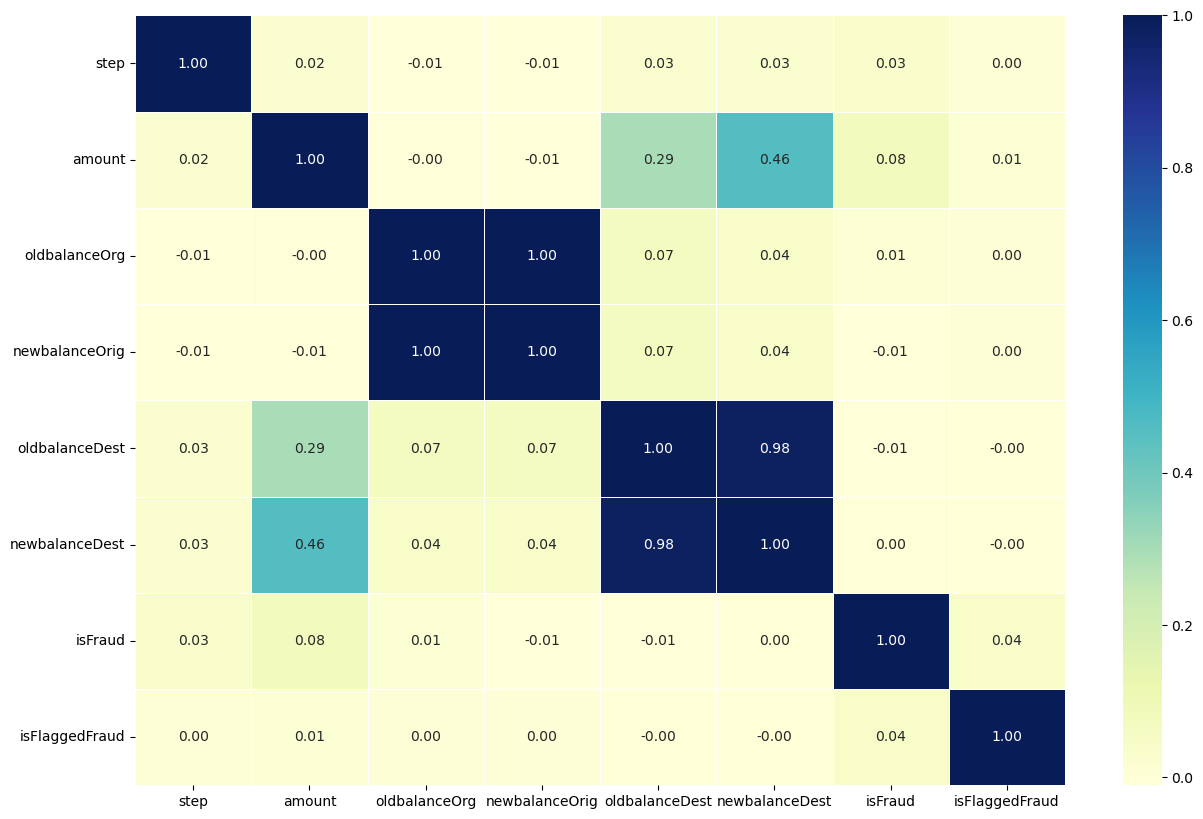

In [63]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

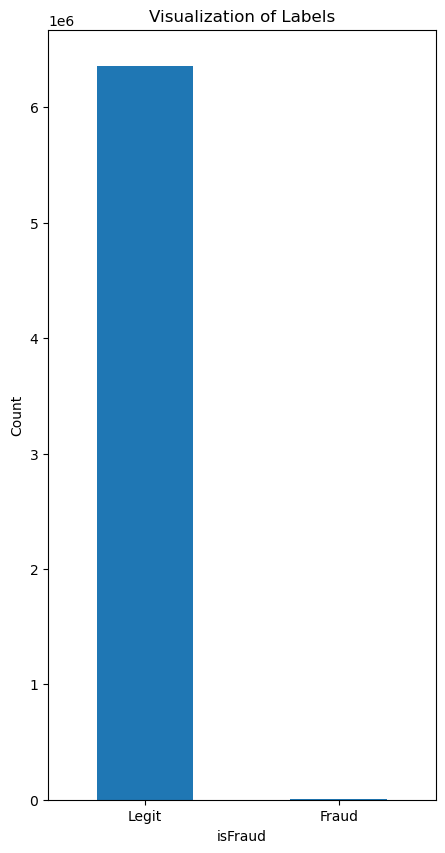

In [64]:
### Number of legit and fraud transactions
plt.figure(figsize=(5,10))
labels = ["Legit", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

### Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.

In [38]:
df_tmp=df.copy()

## Convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

In [39]:
# These columns contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

type
nameOrig
nameDest


In [40]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [41]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        category
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        category
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int64   
 10  isFlaggedFraud  int64   
dtypes: category(3), float64(5), int64(3)
memory usage: 705.7 MB


In [42]:
df_tmp.type.cat.codes

0          3
1          3
2          4
3          1
4          3
          ..
6362615    1
6362616    4
6362617    1
6362618    4
6362619    1
Length: 6362620, dtype: int8

All of our data is categorical and thus we can now turn the categories into numbers

In [43]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1

In [44]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int8   
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(2), int64(3), int8(1)
memory usage: 443.0 MB


We have converted all the columns into numerical values. Now we can carry out with creating the machine learning models

In [45]:
df_tmp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,4,9839.64,757870,170136.0,160296.36,1662095,0.0,0.0,0,0
1,1,4,1864.28,2188999,21249.0,19384.72,1733925,0.0,0.0,0,0
2,1,5,181.00,1002157,181.0,0.00,439686,0.0,0.0,1,0
3,1,2,181.00,5828263,181.0,0.00,391697,21182.0,0.0,1,0
4,1,4,11668.14,3445982,41554.0,29885.86,828920,0.0,0.0,0,0


### Multicollinearity

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(df_tmp)

,variables,VIF
0,step,3.086390
1,type,6.420908
2,amount,4.163217
3,nameOrig,3.079796
4,oldbalanceOrg,565.420556
5,newbalanceOrig,569.883448
6,nameDest,3.311452
7,oldbalanceDest,73.203006
8,newbalanceDest,84.848838
9,isFraud,1.193424


We can see that oldbalanceOrg and newbalanceOrig have too high VIF thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

Thus combine these pairs of collinear attributes and drop the individual ones.

In [72]:
df_tmp['Actual_amount_orig'] = df_tmp.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
df_tmp['Actual_amount_dest'] = df_tmp.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
df_tmp['TransactionPath'] = df_tmp.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
df_tmp = df_tmp.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(df_tmp)


,variables,VIF
0,type,3.776358
1,amount,3.834550
2,isFraud,1.180900
3,isFlaggedFraud,1.002522
4,Actual_amount_orig,1.265989
5,Actual_amount_dest,3.739543
6,TransactionPath,3.734238


<Axes: >

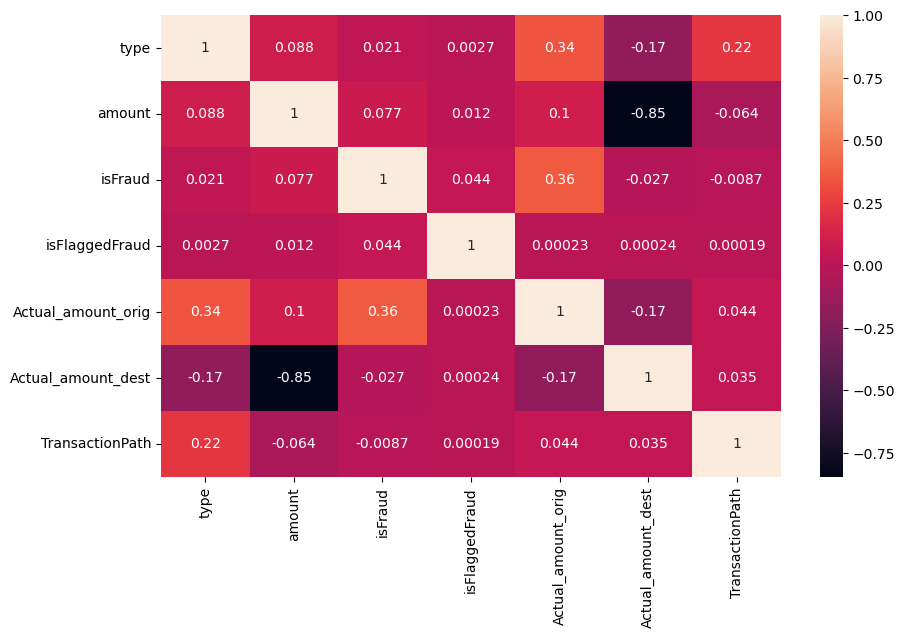

In [74]:
corr=df_tmp.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

How did you select variables to be included in the model?

Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

In [75]:
# Everything except target variable
X = df_tmp.drop("isFraud", axis=1)

# Target variable
y = df_tmp.isFraud.values

In [76]:
# Independent variables (no target column)
X.head()

,type,amount,isFlaggedFraud,Actual_amount_orig,Actual_amount_dest,TransactionPath
0,4,9839.64,0,9839.64,0.0,2419965.0
1,4,1864.28,0,1864.28,0.0,3922924.0
2,5,181.00,0,181.00,0.0,1441843.0
3,2,181.00,0,181.00,21182.0,6219960.0
4,4,11668.14,0,11668.14,0.0,4274902.0


In [77]:
# Targets
y

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

## Now as our data is numerical and does not contain missing values,we can start preparing models

We need to divide the data into training set(calibrating data) and testing set(validation data)

To split our data into a training and test set, we can use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and feed it our independent and dependent variables (`X` & `y`).

In [78]:
# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

We are using 80% of the data to train on and remaining 20% for testing

In [79]:
X_train.head()

,type,amount,isFlaggedFraud,Actual_amount_orig,Actual_amount_dest,TransactionPath
6271196,1,386385.08,0,-386385.07,386385.08,4738368.0
1888243,1,212458.78,0,-212458.78,212458.78,6018157.0
5549957,4,19967.60,0,3634.00,0.00,7216995.0
2025342,2,527616.51,0,180216.00,-527616.51,5542866.0
682342,5,206067.85,0,0.00,-206067.84,5896155.0


In [80]:
y_train,len(y_train)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 5090096)

We are using 5090096 samples to train on

In [81]:
X_test.head()

,type,amount,isFlaggedFraud,Actual_amount_orig,Actual_amount_dest,TransactionPath
3737323,1,330218.42,0,-330218.42,330218.42,5667529.0
264914,4,11647.08,0,11647.08,0.00,2717368.0
85647,1,152264.21,0,-152264.21,152264.21,2632859.0
5899326,5,1551760.63,0,0.00,-1551760.63,4329354.0
2544263,1,78172.30,0,-78172.30,78172.30,5767818.0


In [82]:
y_test,len(y_test)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 1272524)

We are using 1272524 samples for testing purpose

### Model choices

I've got the data prepared, we can start to fit models.I'll be using the following and comparing their results.

1. Logistic Regression - [`LogisticRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
2. K-Nearest Neighbors - [`KNeighboursClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
3. RandomForest - [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

I've referred the scikit learn cheatsheet algorithm for choosing these

In [83]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [88]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'KNN': 0.9992047301268974,
 'Logistic Regression': 0.9985980618047282,
 'Random Forest': 0.9995929349859021}

 ## Model Comparison

Since we've saved our models scores to a dictionary, we can plot them by first converting them to a DataFrame.

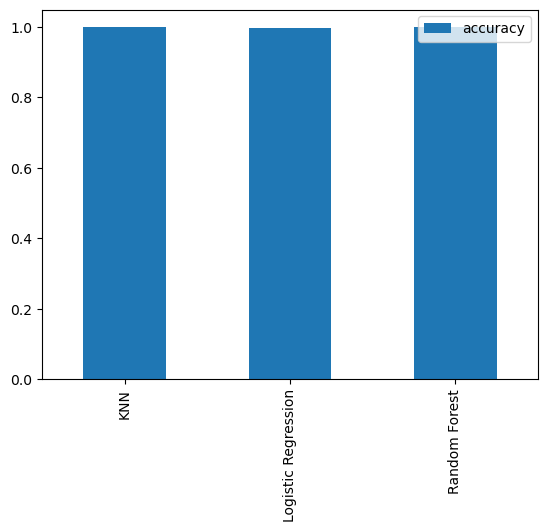

In [85]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

All the models performed well but random forest is slightly better

# Evaluating the model beyond accuracy

## Confusion matrix

In [90]:
#random forest
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)

#Logistic regression
logistic_regression=LogisticRegression()
logistic_regression.fit(X_train,y_train)

y_pred_lr=logistic_regression.predict(X_test)

In [91]:
# key terms of Confusion Matrix - LR

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

# key terms of Confusion Matrix - RF

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 574
False Positives: 738
True Negatives: 1270166
False Negatives: 1046
----------------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 1150
False Positives: 48
True Negatives: 1270856
False Negatives: 470


TP(Logistic regression) < TP(Random Forest) so no competetion here.

FP(Logistic regression) > FP(Random Forest) - Random Forest has an edge

TN(Logistic regression) < TN(Random Forest) - Random Forest is better here too

FN(Logistic regression) > FN(Random Forest)


Here Random Forest looks good.

In [96]:
# confusion matrix - LR

confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_lr,)

print("----------------------------------------------------------------------------------------")

# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Decision Tree
[[1270166     738]
 [   1046     574]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[1270856      48]
 [    470    1150]]


### Classification report

In [93]:
#classification report- LR

classification_report_lr = classification_report(y_test, y_pred_lr)
print("Classification Report - Logistic regression")
print(classification_report_lr)

print("----------------------------------------------------------------------------------------")

# classification report - RF

classification_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

Classification Report - Logistic regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.44      0.35      0.39      1620

    accuracy                           1.00   1272524
   macro avg       0.72      0.68      0.70   1272524
weighted avg       1.00      1.00      1.00   1272524

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.71      0.82      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.85      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



With Such a good precision and hence F1-Score, Random Forest comes out to be better as expected.



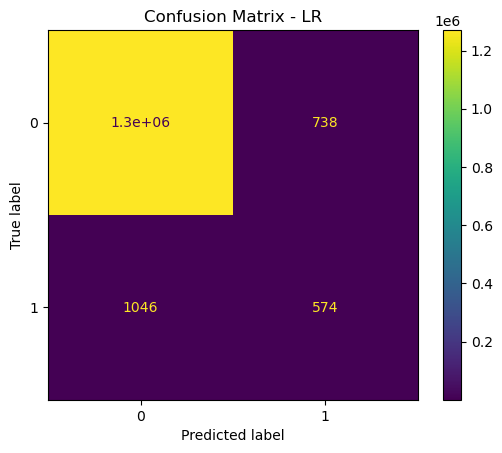

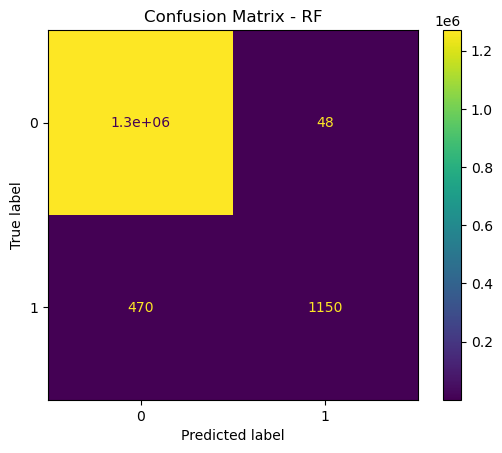

In [97]:
# visualising confusion matrix - LR

from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lr)
disp.plot()
plt.title('Confusion Matrix - LR')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

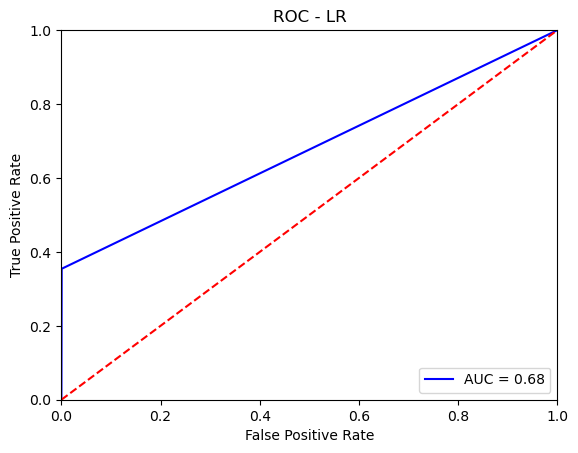

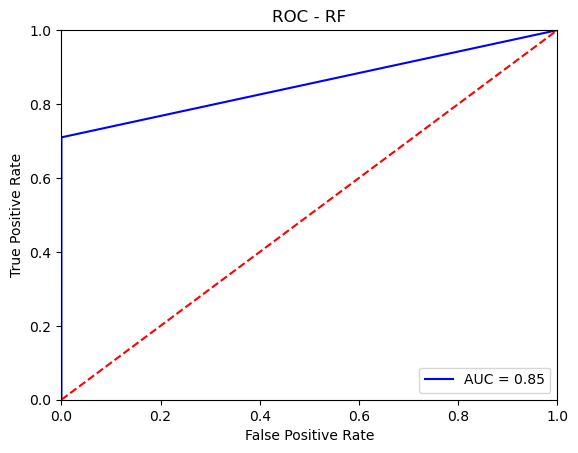

In [100]:
import sklearn.metrics as metrics

# AUC ROC - LR
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_lr)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - LR')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Auc is good for Random forest

# Conclusion

We've seen that Random forest is doing good over Logistic regression and KNeighborsclassifier.
All the 3 were doing good with accuracy but the most important thing is the precision in which Randomforest is the best comparatively.

Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand the data in a simpler way 

What are the key factors that predict fradulent customers?

* The source of request is secured or not?
* Transaction history of vendors

What kind of prevention should be adopted while company update its infrastructure?

* Browse through secured websites
* Don't respond to unsolicited calls/SMS(s/E-mails.
* If you feel like you have been tricked or security compromised, contact your bank immediately.
* Use secured internet connections (USE VPN).

Assuming these actions have been implemented, how would you determine if they work?

* Bank sending E-statements.
* Customers keeping a check of their account activity.
* Always keep a log of your payments.